In [1]:
# import packages used by these scripts
from datetime import datetime
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import numpy as np
import xarray as xr
import shapely.geometry as sgeom
import matplotlib.patches as mpatches
from subprocess import run
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


os.chdir("/Users/etmu9498/research/code/scripts")
import helper_fns
import tc_metadata
import goes_gifs
import make_plots
os.chdir("/Users/etmu9498/research/code/scripts/in-situ-scripts")
import load_in_situ_data


In [2]:
# special helper function to get the in situ index where crl distance from tc center = -100 km or 100 km!
# this is to make the wind speed cross section match with the crl and tdr plots below

def in_situ_lim_helper( in_situ_data_path, in_situ_name):
    # load data
    crl_path = "/Users/etmu9498/research/data/crl-new-matrices"
    tcname='sam'
    dataset=5
    tdr_name, crl_name = tc_metadata.choose_new_data( tcname, dataset)
    os.chdir( crl_path)
    crl_data = xr.open_dataset( crl_name)
    crldist = crl_data.in_situ_distance.values
    
    is_data = load_in_situ_data.load_in_situ( in_situ_data_path, in_situ_name, sample_step_size= 1)
    
    
    # find closest values to crl data lims!
    padding = 100
    idx1 = (np.abs( crldist + padding )).argmin()
    idx2 = (np.abs( crldist - padding )).argmin()
    crllim1 = crl_data.time[idx1]
    crllim2 = crl_data.time[idx2]
    
    # find index of in situ time closest to crl time
    is_idx1 = (np.abs( is_data.float_time - crllim1)).argmin()
    is_idx2 = (np.abs( is_data.float_time - crllim2)).argmin()

    return is_idx1, is_idx2


In [15]:
def goes_plot(goes_names, goes_path, crl_name, crl_path, extent, in_situ_data_path, in_situ_name, tcname=None, dataset=None, clip_path = False):

    # metadata used below
    channel_name = "CMI_C13" # which goes data channel to use
    channel_full_name = "GOES-16 Clean IR Channel" # name of the channel
   
    # get the time of the first goes image for some reason?
    os.chdir( goes_data_path)
    first_dataset = xr.open_dataset( goes_names[ 0])
    scan_start_first_dataset = datetime.strptime( first_dataset.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    # some more metadata options
    plot_color = 'RdYlBu'
    flight_line_color = 'g'
    output_folder = 'csu_figure_' + scan_start_first_dataset.strftime('%m%d%Y')
    
    # figure out the maximum and minimum brightness temperatures in all datasets
    # to make the colorbar constant between runs
    # this is much more complicated in the automatic script, but I just chose values here
    t_max = 290
    t_min = 195
    t_center = 220
    
    # change size of wind speed scatter plot
    scatter_size = 60

    # change most font sizes automatically!
    fsize = 21
    fsize_big = 24
    helper_fns.change_font_sizes(small=fsize, medium=fsize)
    
    
    ###### actually creating the figure now ######
    os.chdir(goes_path)

    # make a singular goes plot! load data
    C = xr.open_dataset( goes_names[ 0])
    
    
    scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ') # Scan's start time, converted to datetime object
    scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ') # Scan's end time, converted to datetime object
    file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ') # File creation time, convert to datetime object
    midpoint = str(C['t'].data)[:-8] # The 't' variable is the scan's midpoint time
    scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

    # access wv data!
    goes_data = C[ channel_name].data

    # make figure
    fig = plt.figure(figsize=(16, 16))
    # these steps use goes ch 2 as a proxy to load things like lat and lon positions
    dat = C.metpy.parse_cf('CMI_C02')
    x = dat.x
    y = dat.y
    geos = dat.metpy.cartopy_crs
    ax = fig.add_subplot(1, 1, 1, projection=geos)

    divnorm = colors.TwoSlopeNorm(vmin=t_min, vcenter=t_center, vmax=t_max)
    # plot goes data
    img = ax.imshow( goes_data, origin='upper',
              cmap= plot_color, # plt.cm.get_cmap( 'cividis').reversed(), # "CMRmap",
              extent=(x.min(), x.max(), y.min(), y.max()),
              transform=geos, norm=divnorm) # vmin=t_min, vmax=t_max)
    
    cbar = fig.colorbar(mappable=img, fraction=0.04, pad=0.05)
    cbar.ax.set_ylabel( ylabel="Brightness Temperature (K)", fontsize=fsize)
    cbar.ax.tick_params(labelsize=14)

    
    # load crl data
    os.chdir( crl_path)
    crl_data = xr.open_dataset( crl_name)
    os.chdir( goes_path)

    # crop data
    ax.set_extent( extent, crs=ccrs.PlateCarree())
    
    # scan time of current goes image
    mid_int = ( int( midpoint[11:13]) + int( midpoint[14:16]) / 60 + int(midpoint[17:19] ) / 3600 )
    print( 'goes time:' + str( mid_int))


    #add shear arrow to plot:
    # load shear data
    metadata = tc_metadata.all_data( tc= tcname)
    shear_mag = metadata[ 'shear_mag'][ dataset]
    shear_dir = metadata[ 'shear_dir'][ dataset] # 90 degrees is from the west

    # make the arrow!
    arrow_mag = .2
    # change from the weird shear dir coordinates to sin + cos coordinates
    shear_dir = 90 - shear_dir
    x_tail = 0.1
    y_tail = 0.1
    x_head = x_tail + np.cos( np.deg2rad( shear_dir)) * arrow_mag
    y_head = y_tail + np.sin( np.deg2rad( shear_dir)) * arrow_mag
    # add arrow
    arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                         mutation_scale=100,
                         transform=ax.transAxes, color='k')
    ax.add_patch(arrow)
    shear_label = 'Environmental Shear: ' + str( shear_mag / 10) + ' kt'
    ax.text( .225, .275, shear_label, c='k', fontsize=fsize,
            bbox={'facecolor': 'w', 'alpha': 1, 'pad': 10},
                verticalalignment='bottom', horizontalalignment='center',
                transform=ax.transAxes)
    
            # transform=ax.transAxes, fontsize=14, linewidth=2, alpha=1, facecolor='w')
    ax.set_ylabel('center / center')


    # in situ data has been provided case
    # load data        
    in_situ = load_in_situ_data.load_in_situ( in_situ_data_path, in_situ_name, sample_step_size= 1)

    print( 'in situ data loaded')

  
    
    # lat and lon labels
    lontxt = "Longitude (" + u'\N{DEGREE SIGN}' + ")"
    lattxt = "Latitude (" + u'\N{DEGREE SIGN}' + ")"

    ax.text( .5, - .10, lontxt, c='k', fontsize=fsize_big,
            verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes)

    ax.text( -.15, .375, lattxt, c='k', fontsize=fsize_big, rotation=90,
           verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes)

    cbar.ax.tick_params(labelsize=fsize)

    helper_fns.change_font_sizes(small=fsize, medium=fsize)

    
    
    
    
    
    # option to only plot some of the in situ data for clarity!
    if clip_path:
                # plot flight path line
            
                # add dots representing limits in lower plo
            
        lon = in_situ.LONref.values[ clip_path[0]: clip_path[1]]
        lon = [ float( value) for value in lon]
        lat = in_situ.LATref.values[ clip_path[0]: clip_path[1]]
        lat = [ float( value) for value in lat]

        # get wind speed data
        ws = in_situ["WS.d"].values[ clip_path[0]: clip_path[1]]
        ws = [ float( line) for line in ws]

    else:
        # plot flight path line
        lon = in_situ.LONref.values
        lon = [ float( value) for value in lon]
        lat = in_situ.LATref.values
        lat = [ float( value) for value in lat]

        # get wind speed data
        ws = in_situ["WS.d"].values
        ws = [ float( line) for line in ws]

    # plot wind speeds!
    proj = ccrs.PlateCarree()
    img2 = ax.scatter( lon, lat,c = ws, transform= proj, s= scatter_size, marker='o', vmin=0, vmax=60, cmap= 'Greens' )
    
    print("Flight Track Added")


    
    




  # hard code to plot dropsondes!
    sonde_path_0929 = "/Users/etmu9498/research/data/dropsondes/noaa-data/20210929H2_NETCDF"
    sonde_path_0930 = "/Users/etmu9498/research/data/dropsondes/noaa-data/20210930H1_NETCDF"
    sonde_list1 = make_plots.load_sondes( sonde_path_0929, print_files=False)
    sonde_list2 = make_plots.load_sondes( sonde_path_0930, print_files=False)

    '''
    # only the last few data points are on the selected flight line, so only choose those!
    os.chdir( sonde_path_0929)
    for i in range( 7, 14):
        sonde = xr.open_dataset( sonde_list1[ i])
        save_sonde = ax.scatter( sonde.reference_lon, sonde.reference_lat, marker='*', s=250, c='b', zorder=1, transform=ccrs.PlateCarree())
    '''

    
    # code to plot all dropsondes
    os.chdir( sonde_path_0929)
    for i in range( len( sonde_list1)): # 7, 14):
        sonde = xr.open_dataset( sonde_list1[ i])
        save_sonde = ax.scatter( sonde.reference_lon, sonde.reference_lat, marker='*', s=250, c='b', zorder=1, transform=ccrs.PlateCarree())
 
    os.chdir( sonde_path_0930)
    for i in range( len( sonde_list2)): # 7, 14):
        sonde = xr.open_dataset( sonde_list2[ i])
        save_sonde = ax.scatter( sonde.reference_lon, sonde.reference_lat, marker='*', s=250, c='b', zorder=1, transform=ccrs.PlateCarree())
    

    # add dot representing tc center!
    # dot = ax.scatter( -57.85, 20.375, s=250, c='k', zorder=1, transform=ccrs.PlateCarree())
    
    
    
    
        

    # add land boundaries to plot
    ax.coastlines()


    # add legend
    shape = mpatches.Rectangle((0, 0), 1, 1, facecolor=flight_line_color)
#    leg = ax.legend([ dot, save_sonde, shape], ['TC Center', 'Sonde Locations', 'P-3 Flight Path'], fontsize=fsize, labelspacing=1.2, borderpad=1.2, facecolor='white', framealpha=1,
#                    loc='upper right', bbox_to_anchor=(1.0, .85))
    leg = ax.legend([ save_sonde, shape], ['Sonde Locations', 'P-3 Flight Path'], fontsize=fsize, labelspacing=1.2, borderpad=1.2, facecolor='white', framealpha=1,
                    loc='upper right', bbox_to_anchor=(1.0, .85))

    leg.get_frame().set_linewidth( 1.5) 
    leg.get_frame().set_edgecolor('k')


    # add titles
    plt.title( channel_full_name, loc='right', fontsize=fsize) # y = manually sets title location
    plt.title( ' TC Sam, 9/29/2021, 21:38 UTC', fontsize=fsize, loc='left' )
    
    # plt.title( ' TC Sam, '+ '{}'.format(scan_start.strftime('%d %B %Y, %H:%M UTC')),
    #           fontsize=15) # loc='left', fontweight='bold'

    # ax.tick_params(axis='both',labelsize=200,direction='out',right=False,top=False)
    gl = ax.gridlines(draw_labels=True) # , linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    
    # add wind speed colorbar!
    cbaxes = inset_axes(ax, width="30%", height="5%", loc=1) # loc=1 puts the special colorbar in the plot!
    # text for wind speed!
    ax.text( .75, .86, "Wind Speed (m/s)", c='k', fontsize=fsize, transform=ax.transAxes)

    cbar2 = plt.colorbar( mappable=img2, cax=cbaxes, orientation='horizontal', fraction=0.04, pad=0.05)
    cbar2.ax.tick_params(labelsize=14)

    # fig.colorbar(mappable=img2, label="Total Wind Speed (m/s)", fraction=0.04, pad=0.05)
    
    # save figure
    os.chdir( "/Users/etmu9498/research/figures/bl-final-project/")
    plt.savefig( "goes-image"".png", dpi=200) # is dpi=200 necessary? # str( file_names[ goes_ind][0: -3] ) + '.png', bbox_inches=0)
    os.chdir( goes_path)


['OR_ABI-L2-MCMIPF-M6_G16_s20212722250206_e20212722259520_c20212722300021.nc']
goes time:22.918333333333333
in situ data loaded
Flight Track Added


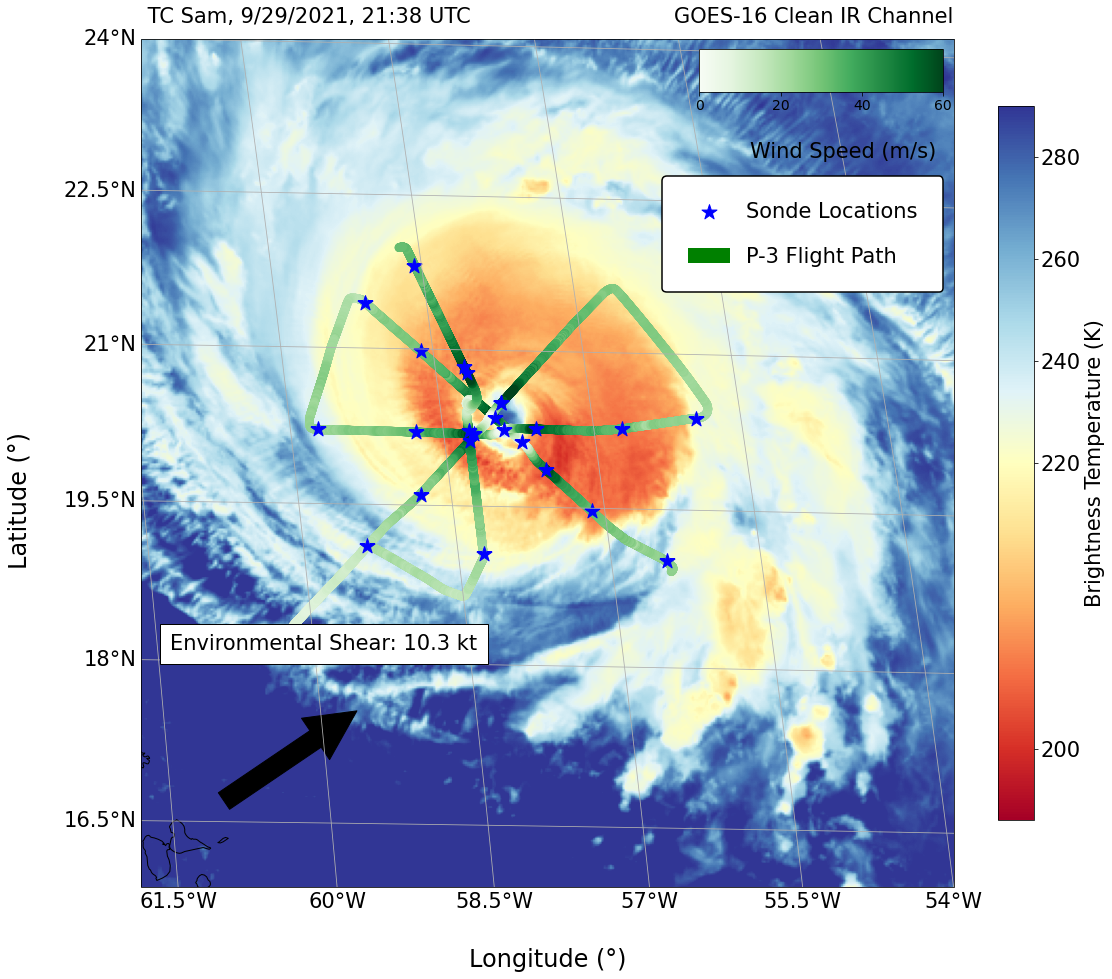

In [16]:
# metadata for this figure

# crl data for star at p-3 location
crl_path = "/Users/etmu9498/research/data/CRL_data/2021"
crl_list = make_plots.load_crl( crl_path, print_files=False)
crl_name = crl_list[ 18]

# in situ data for wind speeds along flight
in_situ_path = "/Users/etmu9498/research/data/in-situ"
in_situ_list = make_plots.load_flight_level(in_situ_path, print_files=False)
in_situ_name = in_situ_list[ 34]

# goes data for satellite image
goes_data_path = "/Users/etmu9498/research/data/goes-satellite/0929_bl_figs"
goes_names = goes_gifs.load_goes( goes_data_path, print_files=False)

print( goes_names)

# more metadata
name = 'sam'
extent = [-61, -54, 16, 24] # [ -61, -55, 18, 23] 
dataset=5 # for shear data!

# clip the in situ data (p-3 flight path) down to this extent!
lim1, lim2 = in_situ_lim_helper( in_situ_path, in_situ_name)
clip = (12000, 30000) # (16500, 19750)
# clip = (lim1.values, lim2.values)

# run the wrapper function to make the figure!
# this figure is also saved at 
goes_plot( goes_names, goes_data_path, crl_name, crl_path, extent, in_situ_path, in_situ_name, tcname=name, dataset=dataset, clip_path=clip)
